# Parametric optimization - inductor

In [2]:
from shapeOptInductor import gen_mesh2, Id
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

## 1 - Geometry and meshing

We define a geometry with 4 control points on the airgap.

In [3]:
airgap = 4.11e-3 * np.array([1, 1, 1, 1])
lz = 1e-2           # thickness in the z-direction (m)
s = 4               # symmetry factor

maxh = 2e-3
mesh = gen_mesh2(airgap, maxh)

XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})

Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, mesh, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2 - State problem

### a) Parameters definition

In [4]:
f = 5e4                 # working frequency (Hz)
omega = 2 * np.pi * f   # rad/s
mu0 = 4e-7 * np.pi      # void permeability (H/m)
mur = 1000              # relative permeability of iron (no unit)
mu_iron = mur * mu0     # permeability of iron (H/m)
delta = 0.1             # loss angle associated with the coil (rad)
mu_coil = np.exp(-1j * delta) * mu0  # complex permeability
nb_turn = 200           # number of turn in the coil (no unit)
Is = 2                  # source current intensity (A)
js = nb_turn / 2 * Is / (ngs.Integrate(XiCoil, mesh)) * XiCoil  # source current density (A/m²)

### b) Definition of the magnetic problem

In [5]:
def magWeakFormComplex(a, a_):
    ''' Return the complex weak form of the magnetic problem, i.e, bilinear 
    and linear forms (matrix and right-hand side after discretization, respectively)'''

    # bilinear form (transmission)
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")

    # linear form (source)
    lf = a_ * js * ngs.dx("coil")

    return bf, lf

def solveStateComplex(mesh):
    ''' Solve the complex magnetic state'''
    # definition of function space
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    a, a_ = fes.TnT()

    # definition of weak form
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf; F += f

    # assembly
    K.Assemble(); F.Assemble()

    # solving
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    gf.vec.data = Kinv * F.vec

    return gf, Kinv # returning Kinv speed up adjoint calculation

### c) Definition of the post-processed quantities

We define the losses and inductance, with the directional derivative of their local quantities.

In [6]:
def Inductance(a, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (Is**2) * ngs.Integrate(rel.real * ngs.Norm(ngs.grad(a)) ** 2, mesh)

def dInductance(a, p_, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return 2 * s * lz / (Is**2) * ngs.InnerProduct(rel.real * ngs.grad(a), ngs.grad(p_)) * ngs.dx()

def Losses(a, mesh):
    rel = XiCoil / mu_coil
    return s * np.pi * f * lz * ngs.Integrate(rel.imag * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def dLosses(a, p_, mesh):
    rel = XiCoil / mu_coil
    return 2 * s * np.pi * f * lz * ngs.InnerProduct(rel.imag * ngs.grad(a), ngs.grad(p_)) * ngs.dx()

## 3 - Adjoint problem

In [7]:
def solveAdjoint(a0, df, Kinv):
    """Solve the adjoint equation for a given df"""
    fes = a0.space
    p, p_ = fes.TnT()
    f = ngs.LinearForm(fes)
    f += -1 * df(a0, p_, fes.mesh)
    f.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * f.vec
    return gf

## 4 - Shape derivative

In [8]:
def SDLosses(a0, p0):
    """Shape derivative for the losses inside the coil"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex = True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_losses = s * np.pi * lz * (1 / mu_coil).imag
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_losses * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx("coil")
    dLOmega += -js * XiCoil * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ

def SDInductance(a0, p0):
    """Shape derivative for the inductance"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex = True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    coeff_induc = s * lz / (Is**2) * rel.real
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_induc * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx
    dLOmega += -js * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ

### Gradient

In [9]:
from shapeOptInductor import referenceVelocity

def shapeGrad(a0, p0, dJ):
    v11, v12, v21, v22 = referenceVelocity(a0.space.mesh)
    dJlf = dJ(a0, p0)
    FES = ngs.VectorH1(a0.space.mesh)
    dJ = ngs.GridFunction(FES)
    dJ.vec.FV().NumPy()[:] = np.real(dJlf.vec.FV().NumPy()[:])
    g11 = ngs.InnerProduct(dJ.vec, v11.vec)
    g12 = ngs.InnerProduct(dJ.vec, v12.vec)
    g21 = ngs.InnerProduct(dJ.vec, v21.vec)
    g22 = ngs.InnerProduct(dJ.vec, v22.vec)
    return g11, g12, g21, g22

## 3 - Optimization

### a) Optimization algorithm
We use an augmented Lagrangian algorithm (saddle point problem) : we maximize with respect to a Lagrange multiplier $l$ a sequence of inner minimization problem with respect to the optimization variables $e$ :

$$ \mathcal L(e,\lambda) = P(e) + \lambda (L(e) - L_0) + \frac{\beta}{2} (L(e) - L_0)^2 $$

In [10]:
# augmented lagrangian
L_target = 1e-3

def innerMinimization(airgap, lam, beta, alpha, n_max=50, alpha_min=1e-5, scale=1e4):
    n = 0
    airgapMin = 1e-4
    airgapMax = 1.49e-2
    mesh = gen_mesh2(airgap, maxh=maxh)
    a, Kinv = solveStateComplex(mesh)
    loss = Losses(a, mesh)
    ind = Inductance(a, mesh)
    objectiveHistory = [loss + lam * (scale * (ind - L_target)) + beta / 2 * (scale * (ind - L_target)) ** 2]
    constraintHistory = [ind - L_target]
    airgapHistory = [airgap.copy()]
    inductanceHistory = [ind]
    lossesHistory = [loss]
    while n < n_max and alpha > alpha_min:
        mesh = gen_mesh2(airgap, maxh=maxh)
        # 1) state computation :
        a, Kinv = solveStateComplex(mesh)

        # 2) adjoint computation :
        pInd = solveAdjoint(a, dInductance, Kinv)
        pLos = solveAdjoint(a, dLosses, Kinv)

        # 3) gradient evaluation :
        gradient = np.array(shapeGrad(a, pLos, SDLosses))
        gradient += lam * scale * np.array(shapeGrad(a, pInd, SDInductance))
        gradient += beta * scale**2 * (Inductance(a, mesh) - L_target) * np.array(shapeGrad(a, pInd, SDInductance))

        # 4) update :
        airgapTest = airgap - alpha * gradient / np.linalg.norm(gradient)
        n += 1

        # 5) projection :
        airgapTest[airgapTest < airgapMin] = airgapMin
        airgapTest[airgapTest > airgapMax] = airgapMax

        # 6) basic step control :
        meshTest = gen_mesh2(airgapTest, maxh=maxh)
        a_test, _ = solveStateComplex(meshTest)
        loss = Losses(a_test, mesh)
        ind = Inductance(a_test, mesh)
        objectiveHistory.append(loss + lam * scale * (ind - L_target) + beta / 2 * (scale * (ind - L_target)) ** 2)
        constraintHistory.append(ind - L_target)
        inductanceHistory.append(ind)
        lossesHistory.append(loss)

        print(
            f"it n°{n} | f = {objectiveHistory[-1] :.5e} | L = {inductanceHistory[-1]:.5e} | P = {lossesHistory[-1]:.5e} | step = {alpha : .2e}"
        )

        if objectiveHistory[-1] >= objectiveHistory[-2]:
            alpha = alpha / 2
            objectiveHistory.pop()
            constraintHistory.pop()
            inductanceHistory.pop()
            lossesHistory.pop()
        elif objectiveHistory[-1] < objectiveHistory[-2]:
            alpha = alpha * 1.2
            airgap = airgapTest
            airgapHistory.append(airgap)
    return airgap, alpha, objectiveHistory, constraintHistory, lossesHistory, inductanceHistory, airgapHistory



### b) Optimization Loop

In [11]:
## Initialisation

lam = 0
scale = 1e3
beta = 500  # Coefficient de pénalisation (à faire varier)
alpha = 1e-3 / 2  # Pas initial
airgap = 4.11e-3 * np.array([1, 1, 1, 1])

alpha_min = 1e-7  # Pas minimal
N_max = 20  # Nombre d'itérations de l'algorithme d'optimisation
n_max = 20

ConstList = []
LagrList = []
lamList = [lam]
LossList = []
InductanceList = []
AirgapList = []
N = 0
while N < N_max:
    airgap, alpha, lagrList, constList, lossList, inductanceList, airgapList = innerMinimization(
        airgap, lam, beta, alpha=2 * alpha, n_max=n_max, alpha_min=alpha_min, scale=scale
    )
    lam += beta * constList[-1]
    print(f"{lam = }")
    lamList.append(lam)
    LagrList += lagrList
    ConstList += constList
    LossList += lossList
    InductanceList += inductanceList
    AirgapList += airgapList
    N += 1

it n°1 | f = 1.56137e+01 | L = 8.75634e-04 | P = 1.17470e+01 | step =  1.00e-03
it n°2 | f = 1.36113e+01 | L = 9.31703e-04 | P = 1.24452e+01 | step =  5.00e-04
it n°3 | f = 1.31069e+01 | L = 9.62756e-04 | P = 1.27601e+01 | step =  2.50e-04
it n°4 | f = 1.27139e+01 | L = 9.63012e-04 | P = 1.23719e+01 | step =  3.00e-04
it n°5 | f = 1.21328e+01 | L = 9.83101e-04 | P = 1.20614e+01 | step =  3.60e-04
it n°6 | f = 1.16762e+01 | L = 9.82871e-04 | P = 1.16028e+01 | step =  4.32e-04
it n°7 | f = 1.11407e+01 | L = 9.95674e-04 | P = 1.11360e+01 | step =  5.18e-04
it n°8 | f = 1.05312e+01 | L = 1.00898e-03 | P = 1.05111e+01 | step =  6.22e-04
it n°9 | f = 9.75596e+00 | L = 1.00397e-03 | P = 9.75202e+00 | step =  7.46e-04
it n°10 | f = 1.06902e+01 | L = 1.08273e-03 | P = 8.97905e+00 | step =  8.96e-04
it n°11 | f = 9.52946e+00 | L = 1.02685e-03 | P = 9.34917e+00 | step =  4.48e-04
it n°12 | f = 9.16227e+00 | L = 9.65895e-04 | P = 8.87147e+00 | step =  5.37e-04
it n°13 | f = 1.80668e+01 | L = 1.195

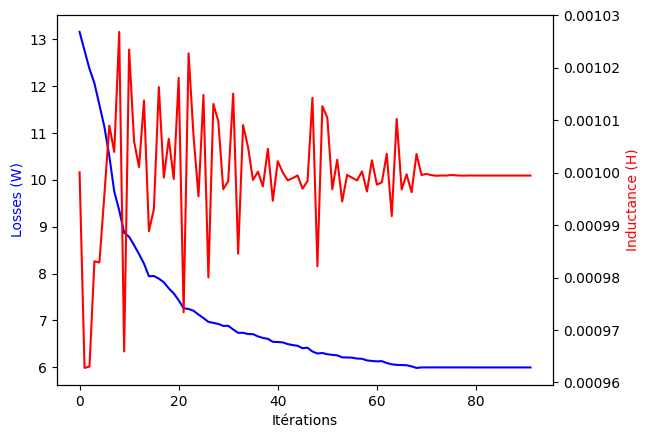

In [12]:
# Display convergence

ax1 = plt.plot(LossList, color="b")
plt.ylabel("Losses (W)", color="b")
plt.xlabel("Itérations")
ax2 = plt.gca().twinx()
ax2.plot(InductanceList, color="r")
plt.ylabel("Inductance (H)", color="r")
plt.show()

In [13]:
print(f"It : {len(InductanceList)} | P = {LossList[-1]:.2f} W | L = {InductanceList[-1]*1e3 :.2f} mH ")
mesh = gen_mesh2(AirgapList[-1], maxh = maxh)
Draw(mesh)

It : 92 | P = 6.00 W | L = 1.00 mH 


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene